## EN2550 Assignment 1 on Fitting and Alignment

190574U </br> Induwara Senadheera

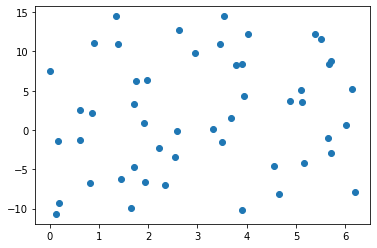

In [7]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
# np . random. seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r /16
t = np . random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random. randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )

fig,ax=plt.subplots()

plt.scatter(t,y)

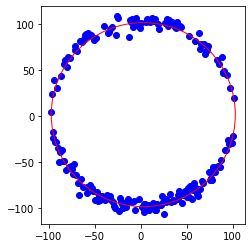

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

def data_generator():
	x_data = []
	y_data = []

	a = 2
	b = 3
	r = 100

	for i in np.arange(a - r, a + r, 1):
		x = i
		y = 0
		y1, y2 = circle_func(a, b, r, x)
		if np.random.randn() > 0:
			y += y1 + np.random.randn()*5
		else:
			y += y2 + np.random.randn()*5
		x_data.append(x)
		y_data.append(y)

	return x_data, y_data

def circle_func(a, b, r, x):
	return (np.sqrt(r**2-(x-a)**2) + b, -np.sqrt(r**2-(x-a)**2) + b)

class RANSAC:
	def __init__(self, x_data, y_data, n):
		self.x_data = x_data
		self.y_data = y_data
		self.n = n
		self.d_min = 99999
		self.best_model = None

	def random_sampling(self):
		sample = []
		save_ran = []
		count = 0

		# get three points from data
		while True:
			ran = np.random.randint(len(self.x_data))

			if ran not in save_ran:
				sample.append((self.x_data[ran], self.y_data[ran]))
				save_ran.append(ran)
				count += 1

				if count == 3:
					break

		return sample

	def make_model(self, sample):
		# calculate A, B, C value from three points by using matrix
	
		pt1 = sample[0]
		pt2 = sample[1]
		pt3 = sample[2]

		A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]]) 
		B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])		
		inv_A = inv(A)

		c_x, c_y = np.dot(inv_A, B) / 2
		c_x, c_y = c_x[0], c_y[0]
		r = np.sqrt((c_x - pt1[0])**2 + (c_y - pt1[1])**2)

		return c_x, c_y, r

	def eval_model(self, model):
		d = 0
		c_x, c_y, r = model

		for i in range(len(self.x_data)):
			dis = np.sqrt((self.x_data[i]-c_x)**2 + (self.y_data[i]-c_y)**2)

			if dis >= r:
				d += dis - r
			else:
				d += r - dis
		
		return d

	def execute_ransac(self):
		# find best model
		for i in range(self.n):
			model = self.make_model(self.random_sampling())
			d_temp = self.eval_model(model)
			
			if self.d_min > d_temp:
				self.best_model = model
				self.d_min = d_temp


if __name__ == '__main__':
	# make data
	x_data, y_data = data_generator()

	# show data by scatter type
	plt.scatter(x_data, y_data, c='blue', marker='o', label='data')

	# make ransac class
	# n: how many times try sampling
	ransac = RANSAC(x_data, y_data, 50)
	
	# execute ransac algorithm
	ransac.execute_ransac()
	
	# get best model from ransac
	a, b, r = ransac.best_model[0], ransac.best_model[1], ransac.best_model[2]

	# show result
	circle = plt.Circle((a, b), radius=r, color='r', fc='y', fill=False)
	plt.gca().add_patch(circle)

	plt.axis('scaled')

	# plt.tight_layout()
	plt.show()